In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (1.0, 1.0, 1.0, 1.0)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset_scaled.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.cloud_mask_net = Unet(
            encoder_name='resnet34',
            in_channels=16,
            classes=1,
        )

        self.cloud_phase_net = Unet(
            encoder_name='resnet34',
            in_channels=17,
            classes=5,
        )
        self.cod_net = Unet(
            encoder_name='resnet34',
            in_channels=17,
            classes=1,
        )
        self.cps_net = Unet(
            encoder_name='resnet34',
            in_channels=17,
            classes=1,
        )

    def forward(self, x):
        cloud_mask_pred = self.cloud_mask_net(x)  # [B,1,H,W]
        x1 = torch.cat([x, cloud_mask_pred], dim=1)  # [B,17,H,W]

        cloud_phase_pred = self.cloud_phase_net(x1)  # [B,5,H,W]
        cod_pred = self.cod_net(x1)                # [B,1,H,W]
        cps_pred = self.cps_net(x1)                # [B,1,H,W]

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred



In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV1().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f} | Val Mask: {val_results['acc_mask']:.4f} | Val Phase: {val_results['acc_phase']:.4f} | Val Cod: {val_results['r2_cod']:.4f} | Val Cps: {val_results['r2_cps']:.4f}")


100%|██████████| 94/94 [00:28<00:00,  3.35it/s]


Epoch: 1 | Train Loss: 9.6385 | Val Loss: 8.8883 | Val Mask: 0.2381 | Val Phase: 0.5441 | Val Cod: -0.2227 | Val Cps: -1.2275


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 2 | Train Loss: 7.1475 | Val Loss: 6.6959 | Val Mask: 0.2468 | Val Phase: 0.6498 | Val Cod: 0.1177 | Val Cps: -0.5657


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 3 | Train Loss: 5.8811 | Val Loss: 5.4321 | Val Mask: 0.2561 | Val Phase: 0.6902 | Val Cod: 0.3610 | Val Cps: -0.2158


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 4 | Train Loss: 5.0673 | Val Loss: 4.8303 | Val Mask: 0.2695 | Val Phase: 0.7102 | Val Cod: 0.4377 | Val Cps: -0.0543


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 5 | Train Loss: 4.4891 | Val Loss: 4.3542 | Val Mask: 0.2768 | Val Phase: 0.7406 | Val Cod: 0.4841 | Val Cps: 0.0789


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 6 | Train Loss: 4.0430 | Val Loss: 3.9749 | Val Mask: 0.2975 | Val Phase: 0.7550 | Val Cod: 0.4726 | Val Cps: 0.2120


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 7 | Train Loss: 3.6915 | Val Loss: 3.5270 | Val Mask: 0.3098 | Val Phase: 0.7663 | Val Cod: 0.5068 | Val Cps: 0.3534


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 8 | Train Loss: 3.4221 | Val Loss: 3.1797 | Val Mask: 0.3291 | Val Phase: 0.7840 | Val Cod: 0.5482 | Val Cps: 0.4567


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 9 | Train Loss: 3.1877 | Val Loss: 3.0559 | Val Mask: 0.3376 | Val Phase: 0.7939 | Val Cod: 0.5731 | Val Cps: 0.4735


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 10 | Train Loss: 2.9833 | Val Loss: 2.8662 | Val Mask: 0.3574 | Val Phase: 0.7959 | Val Cod: 0.5908 | Val Cps: 0.5322


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 11 | Train Loss: 2.8134 | Val Loss: 2.7297 | Val Mask: 0.3710 | Val Phase: 0.8116 | Val Cod: 0.5844 | Val Cps: 0.5728


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 12 | Train Loss: 2.6961 | Val Loss: 2.8491 | Val Mask: 0.3982 | Val Phase: 0.7454 | Val Cod: 0.5924 | Val Cps: 0.5720


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 13 | Train Loss: 2.5710 | Val Loss: 2.5525 | Val Mask: 0.4267 | Val Phase: 0.8209 | Val Cod: 0.6111 | Val Cps: 0.6081


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 14 | Train Loss: 2.4746 | Val Loss: 2.6258 | Val Mask: 0.4485 | Val Phase: 0.8241 | Val Cod: 0.6197 | Val Cps: 0.5644


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 15 | Train Loss: 2.3972 | Val Loss: 2.5976 | Val Mask: 0.4908 | Val Phase: 0.7990 | Val Cod: 0.6498 | Val Cps: 0.5857


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 16 | Train Loss: 2.3102 | Val Loss: 2.4019 | Val Mask: 0.5326 | Val Phase: 0.8338 | Val Cod: 0.6584 | Val Cps: 0.6223


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 17 | Train Loss: 2.2589 | Val Loss: 2.4128 | Val Mask: 0.5695 | Val Phase: 0.8316 | Val Cod: 0.6315 | Val Cps: 0.6298


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 18 | Train Loss: 2.2145 | Val Loss: 2.3479 | Val Mask: 0.6671 | Val Phase: 0.8232 | Val Cod: 0.6575 | Val Cps: 0.6479


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 19 | Train Loss: 2.1606 | Val Loss: 2.4080 | Val Mask: 0.7181 | Val Phase: 0.8299 | Val Cod: 0.6602 | Val Cps: 0.6134


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 20 | Train Loss: 2.1255 | Val Loss: 2.3537 | Val Mask: 0.7655 | Val Phase: 0.8331 | Val Cod: 0.6621 | Val Cps: 0.6230


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 21 | Train Loss: 2.0897 | Val Loss: 2.2849 | Val Mask: 0.7953 | Val Phase: 0.8114 | Val Cod: 0.6662 | Val Cps: 0.6703


100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Epoch: 22 | Train Loss: 2.0521 | Val Loss: 2.1692 | Val Mask: 0.8019 | Val Phase: 0.8445 | Val Cod: 0.6823 | Val Cps: 0.6741


100%|██████████| 94/94 [00:25<00:00,  3.73it/s]


Epoch: 23 | Train Loss: 2.0169 | Val Loss: 2.2403 | Val Mask: 0.8005 | Val Phase: 0.8407 | Val Cod: 0.6435 | Val Cps: 0.6623


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 24 | Train Loss: 1.9914 | Val Loss: 2.3549 | Val Mask: 0.8046 | Val Phase: 0.7995 | Val Cod: 0.6646 | Val Cps: 0.6370


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 25 | Train Loss: 1.9574 | Val Loss: 2.2188 | Val Mask: 0.7956 | Val Phase: 0.8284 | Val Cod: 0.6604 | Val Cps: 0.6685


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 26 | Train Loss: 1.9290 | Val Loss: 2.1591 | Val Mask: 0.7922 | Val Phase: 0.8126 | Val Cod: 0.6902 | Val Cps: 0.6862


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 27 | Train Loss: 1.8988 | Val Loss: 2.1108 | Val Mask: 0.7875 | Val Phase: 0.8284 | Val Cod: 0.6842 | Val Cps: 0.6849


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 28 | Train Loss: 1.8763 | Val Loss: 2.1112 | Val Mask: 0.7876 | Val Phase: 0.8342 | Val Cod: 0.6727 | Val Cps: 0.6842


100%|██████████| 94/94 [00:25<00:00,  3.70it/s]


Epoch: 29 | Train Loss: 1.8439 | Val Loss: 2.0718 | Val Mask: 0.7871 | Val Phase: 0.8443 | Val Cod: 0.6694 | Val Cps: 0.6811


100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Epoch: 30 | Train Loss: 1.8230 | Val Loss: 2.0233 | Val Mask: 0.7934 | Val Phase: 0.8360 | Val Cod: 0.7029 | Val Cps: 0.6933


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 31 | Train Loss: 1.7801 | Val Loss: 2.0028 | Val Mask: 0.8007 | Val Phase: 0.8405 | Val Cod: 0.6884 | Val Cps: 0.6862


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 32 | Train Loss: 1.7633 | Val Loss: 1.9444 | Val Mask: 0.8240 | Val Phase: 0.8481 | Val Cod: 0.7038 | Val Cps: 0.6930


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 33 | Train Loss: 1.7220 | Val Loss: 2.0466 | Val Mask: 0.8338 | Val Phase: 0.8154 | Val Cod: 0.7052 | Val Cps: 0.6777


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 34 | Train Loss: 1.7057 | Val Loss: 1.9330 | Val Mask: 0.8432 | Val Phase: 0.8529 | Val Cod: 0.7064 | Val Cps: 0.6780


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 35 | Train Loss: 1.6834 | Val Loss: 1.8589 | Val Mask: 0.8456 | Val Phase: 0.8468 | Val Cod: 0.7095 | Val Cps: 0.7048


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 36 | Train Loss: 1.6642 | Val Loss: 1.8926 | Val Mask: 0.8504 | Val Phase: 0.8425 | Val Cod: 0.6856 | Val Cps: 0.7078


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 37 | Train Loss: 1.6254 | Val Loss: 1.8359 | Val Mask: 0.8585 | Val Phase: 0.8525 | Val Cod: 0.7107 | Val Cps: 0.6983


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 38 | Train Loss: 1.5998 | Val Loss: 1.7793 | Val Mask: 0.8609 | Val Phase: 0.8576 | Val Cod: 0.7117 | Val Cps: 0.7102


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 39 | Train Loss: 1.5813 | Val Loss: 1.7784 | Val Mask: 0.8675 | Val Phase: 0.8589 | Val Cod: 0.7159 | Val Cps: 0.7024


100%|██████████| 94/94 [00:24<00:00,  3.76it/s]


Epoch: 40 | Train Loss: 1.5565 | Val Loss: 1.8537 | Val Mask: 0.8702 | Val Phase: 0.8364 | Val Cod: 0.7146 | Val Cps: 0.6870


100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


Epoch: 41 | Train Loss: 1.5458 | Val Loss: 1.7683 | Val Mask: 0.8742 | Val Phase: 0.8566 | Val Cod: 0.7074 | Val Cps: 0.7014


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 42 | Train Loss: 1.5288 | Val Loss: 1.7431 | Val Mask: 0.8778 | Val Phase: 0.8546 | Val Cod: 0.7222 | Val Cps: 0.7034


100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Epoch: 43 | Train Loss: 1.5128 | Val Loss: 1.7243 | Val Mask: 0.8828 | Val Phase: 0.8563 | Val Cod: 0.7198 | Val Cps: 0.7043


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 44 | Train Loss: 1.5061 | Val Loss: 1.7748 | Val Mask: 0.8860 | Val Phase: 0.8575 | Val Cod: 0.6877 | Val Cps: 0.6936


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 45 | Train Loss: 1.4715 | Val Loss: 1.6667 | Val Mask: 0.8897 | Val Phase: 0.8588 | Val Cod: 0.7211 | Val Cps: 0.7190


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 46 | Train Loss: 1.4507 | Val Loss: 1.7090 | Val Mask: 0.8914 | Val Phase: 0.8567 | Val Cod: 0.7072 | Val Cps: 0.7078


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 47 | Train Loss: 1.4405 | Val Loss: 1.7666 | Val Mask: 0.8943 | Val Phase: 0.8571 | Val Cod: 0.6780 | Val Cps: 0.6925


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 48 | Train Loss: 1.4213 | Val Loss: 1.6398 | Val Mask: 0.8975 | Val Phase: 0.8579 | Val Cod: 0.7263 | Val Cps: 0.7138


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 49 | Train Loss: 1.4049 | Val Loss: 1.6394 | Val Mask: 0.8984 | Val Phase: 0.8520 | Val Cod: 0.7252 | Val Cps: 0.7158


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 50 | Train Loss: 1.3891 | Val Loss: 1.6745 | Val Mask: 0.9013 | Val Phase: 0.8573 | Val Cod: 0.7139 | Val Cps: 0.6967


100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


Epoch: 51 | Train Loss: 1.3639 | Val Loss: 1.6897 | Val Mask: 0.9027 | Val Phase: 0.8501 | Val Cod: 0.7115 | Val Cps: 0.6938


100%|██████████| 94/94 [00:25<00:00,  3.70it/s]


Epoch: 52 | Train Loss: 1.3629 | Val Loss: 1.6480 | Val Mask: 0.9038 | Val Phase: 0.8564 | Val Cod: 0.7066 | Val Cps: 0.7121


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 53 | Train Loss: 1.3395 | Val Loss: 1.6438 | Val Mask: 0.9063 | Val Phase: 0.8613 | Val Cod: 0.7196 | Val Cps: 0.6947


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 54 | Train Loss: 1.3239 | Val Loss: 1.5877 | Val Mask: 0.9079 | Val Phase: 0.8631 | Val Cod: 0.7204 | Val Cps: 0.7120


100%|██████████| 94/94 [00:24<00:00,  3.76it/s]


Epoch: 55 | Train Loss: 1.3206 | Val Loss: 1.6867 | Val Mask: 0.9081 | Val Phase: 0.8601 | Val Cod: 0.7031 | Val Cps: 0.6816


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 56 | Train Loss: 1.3072 | Val Loss: 1.6167 | Val Mask: 0.9064 | Val Phase: 0.8497 | Val Cod: 0.7134 | Val Cps: 0.7169


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 57 | Train Loss: 1.2947 | Val Loss: 1.5592 | Val Mask: 0.9128 | Val Phase: 0.8600 | Val Cod: 0.7324 | Val Cps: 0.7187


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 58 | Train Loss: 1.2680 | Val Loss: 1.5290 | Val Mask: 0.9141 | Val Phase: 0.8608 | Val Cod: 0.7304 | Val Cps: 0.7280


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 59 | Train Loss: 1.2682 | Val Loss: 1.5399 | Val Mask: 0.9154 | Val Phase: 0.8652 | Val Cod: 0.7266 | Val Cps: 0.7175


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 60 | Train Loss: 1.2558 | Val Loss: 1.5779 | Val Mask: 0.9159 | Val Phase: 0.8550 | Val Cod: 0.7296 | Val Cps: 0.7199


100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Epoch: 61 | Train Loss: 1.2490 | Val Loss: 1.5308 | Val Mask: 0.9176 | Val Phase: 0.8613 | Val Cod: 0.7327 | Val Cps: 0.7215


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 62 | Train Loss: 1.2342 | Val Loss: 1.5259 | Val Mask: 0.9183 | Val Phase: 0.8639 | Val Cod: 0.7353 | Val Cps: 0.7196


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 63 | Train Loss: 1.2320 | Val Loss: 1.5318 | Val Mask: 0.9194 | Val Phase: 0.8574 | Val Cod: 0.7298 | Val Cps: 0.7214


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 64 | Train Loss: 1.2207 | Val Loss: 1.5482 | Val Mask: 0.9200 | Val Phase: 0.8604 | Val Cod: 0.7292 | Val Cps: 0.7131


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 65 | Train Loss: 1.2204 | Val Loss: 1.4759 | Val Mask: 0.9210 | Val Phase: 0.8577 | Val Cod: 0.7380 | Val Cps: 0.7355


100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Epoch: 66 | Train Loss: 1.2127 | Val Loss: 1.4971 | Val Mask: 0.9198 | Val Phase: 0.8678 | Val Cod: 0.7354 | Val Cps: 0.7217


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 67 | Train Loss: 1.1945 | Val Loss: 1.4758 | Val Mask: 0.9235 | Val Phase: 0.8625 | Val Cod: 0.7367 | Val Cps: 0.7352


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 68 | Train Loss: 1.1886 | Val Loss: 1.5192 | Val Mask: 0.9171 | Val Phase: 0.8620 | Val Cod: 0.7424 | Val Cps: 0.7222


100%|██████████| 94/94 [00:25<00:00,  3.73it/s]


Epoch: 69 | Train Loss: 1.1796 | Val Loss: 1.5129 | Val Mask: 0.9241 | Val Phase: 0.8570 | Val Cod: 0.7341 | Val Cps: 0.7205


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 70 | Train Loss: 1.1803 | Val Loss: 1.4834 | Val Mask: 0.9246 | Val Phase: 0.8640 | Val Cod: 0.7411 | Val Cps: 0.7288


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 71 | Train Loss: 1.1658 | Val Loss: 1.4565 | Val Mask: 0.9243 | Val Phase: 0.8669 | Val Cod: 0.7425 | Val Cps: 0.7330


100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Epoch: 72 | Train Loss: 1.1569 | Val Loss: 1.4819 | Val Mask: 0.9202 | Val Phase: 0.8624 | Val Cod: 0.7421 | Val Cps: 0.7272


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 73 | Train Loss: 1.1607 | Val Loss: 1.4715 | Val Mask: 0.9276 | Val Phase: 0.8664 | Val Cod: 0.7436 | Val Cps: 0.7219


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 74 | Train Loss: 1.1507 | Val Loss: 1.4738 | Val Mask: 0.9268 | Val Phase: 0.8631 | Val Cod: 0.7363 | Val Cps: 0.7246


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 75 | Train Loss: 1.1364 | Val Loss: 1.4793 | Val Mask: 0.9250 | Val Phase: 0.8596 | Val Cod: 0.7394 | Val Cps: 0.7351


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 76 | Train Loss: 1.1324 | Val Loss: 1.4781 | Val Mask: 0.9290 | Val Phase: 0.8640 | Val Cod: 0.7425 | Val Cps: 0.7264


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 77 | Train Loss: 1.1262 | Val Loss: 1.4975 | Val Mask: 0.9259 | Val Phase: 0.8647 | Val Cod: 0.7227 | Val Cps: 0.7223


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 78 | Train Loss: 1.1256 | Val Loss: 1.4646 | Val Mask: 0.9290 | Val Phase: 0.8634 | Val Cod: 0.7390 | Val Cps: 0.7349


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 79 | Train Loss: 1.1204 | Val Loss: 1.4177 | Val Mask: 0.9306 | Val Phase: 0.8709 | Val Cod: 0.7452 | Val Cps: 0.7354


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 80 | Train Loss: 1.1070 | Val Loss: 1.4526 | Val Mask: 0.9253 | Val Phase: 0.8616 | Val Cod: 0.7402 | Val Cps: 0.7351


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 81 | Train Loss: 1.0999 | Val Loss: 1.4323 | Val Mask: 0.9322 | Val Phase: 0.8706 | Val Cod: 0.7421 | Val Cps: 0.7278


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 82 | Train Loss: 1.0997 | Val Loss: 1.4259 | Val Mask: 0.9319 | Val Phase: 0.8661 | Val Cod: 0.7423 | Val Cps: 0.7380


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 83 | Train Loss: 1.0855 | Val Loss: 1.4115 | Val Mask: 0.9339 | Val Phase: 0.8693 | Val Cod: 0.7434 | Val Cps: 0.7401


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 84 | Train Loss: 1.0903 | Val Loss: 1.4465 | Val Mask: 0.9339 | Val Phase: 0.8658 | Val Cod: 0.7343 | Val Cps: 0.7293


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 85 | Train Loss: 1.0877 | Val Loss: 1.4330 | Val Mask: 0.9335 | Val Phase: 0.8601 | Val Cod: 0.7490 | Val Cps: 0.7407


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 86 | Train Loss: 1.0810 | Val Loss: 1.4551 | Val Mask: 0.9336 | Val Phase: 0.8650 | Val Cod: 0.7270 | Val Cps: 0.7297


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 87 | Train Loss: 1.0805 | Val Loss: 1.4168 | Val Mask: 0.9333 | Val Phase: 0.8620 | Val Cod: 0.7394 | Val Cps: 0.7440


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 88 | Train Loss: 1.0720 | Val Loss: 1.4885 | Val Mask: 0.9333 | Val Phase: 0.8534 | Val Cod: 0.7435 | Val Cps: 0.7372


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 89 | Train Loss: 1.0700 | Val Loss: 1.4710 | Val Mask: 0.9358 | Val Phase: 0.8585 | Val Cod: 0.7395 | Val Cps: 0.7308


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 90 | Train Loss: 1.0613 | Val Loss: 1.4112 | Val Mask: 0.9291 | Val Phase: 0.8641 | Val Cod: 0.7439 | Val Cps: 0.7412


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 91 | Train Loss: 1.0544 | Val Loss: 1.5483 | Val Mask: 0.9333 | Val Phase: 0.8546 | Val Cod: 0.7433 | Val Cps: 0.7102


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 92 | Train Loss: 1.0509 | Val Loss: 1.4101 | Val Mask: 0.9296 | Val Phase: 0.8699 | Val Cod: 0.7463 | Val Cps: 0.7397


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 93 | Train Loss: 1.0507 | Val Loss: 1.4855 | Val Mask: 0.9313 | Val Phase: 0.8551 | Val Cod: 0.7474 | Val Cps: 0.7336


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 94 | Train Loss: 1.0434 | Val Loss: 1.4525 | Val Mask: 0.9359 | Val Phase: 0.8681 | Val Cod: 0.6886 | Val Cps: 0.7430


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 95 | Train Loss: 1.0434 | Val Loss: 1.4246 | Val Mask: 0.9279 | Val Phase: 0.8702 | Val Cod: 0.7429 | Val Cps: 0.7339


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 96 | Train Loss: 1.0361 | Val Loss: 1.5102 | Val Mask: 0.9162 | Val Phase: 0.8485 | Val Cod: 0.7440 | Val Cps: 0.7295


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 97 | Train Loss: 1.0340 | Val Loss: 1.3863 | Val Mask: 0.9386 | Val Phase: 0.8716 | Val Cod: 0.7392 | Val Cps: 0.7438


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 98 | Train Loss: 1.0266 | Val Loss: 1.4131 | Val Mask: 0.9344 | Val Phase: 0.8606 | Val Cod: 0.7516 | Val Cps: 0.7423


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 99 | Train Loss: 1.0214 | Val Loss: 1.4035 | Val Mask: 0.9350 | Val Phase: 0.8714 | Val Cod: 0.7309 | Val Cps: 0.7439


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 100 | Train Loss: 1.0222 | Val Loss: 1.4592 | Val Mask: 0.9347 | Val Phase: 0.8571 | Val Cod: 0.7387 | Val Cps: 0.7387


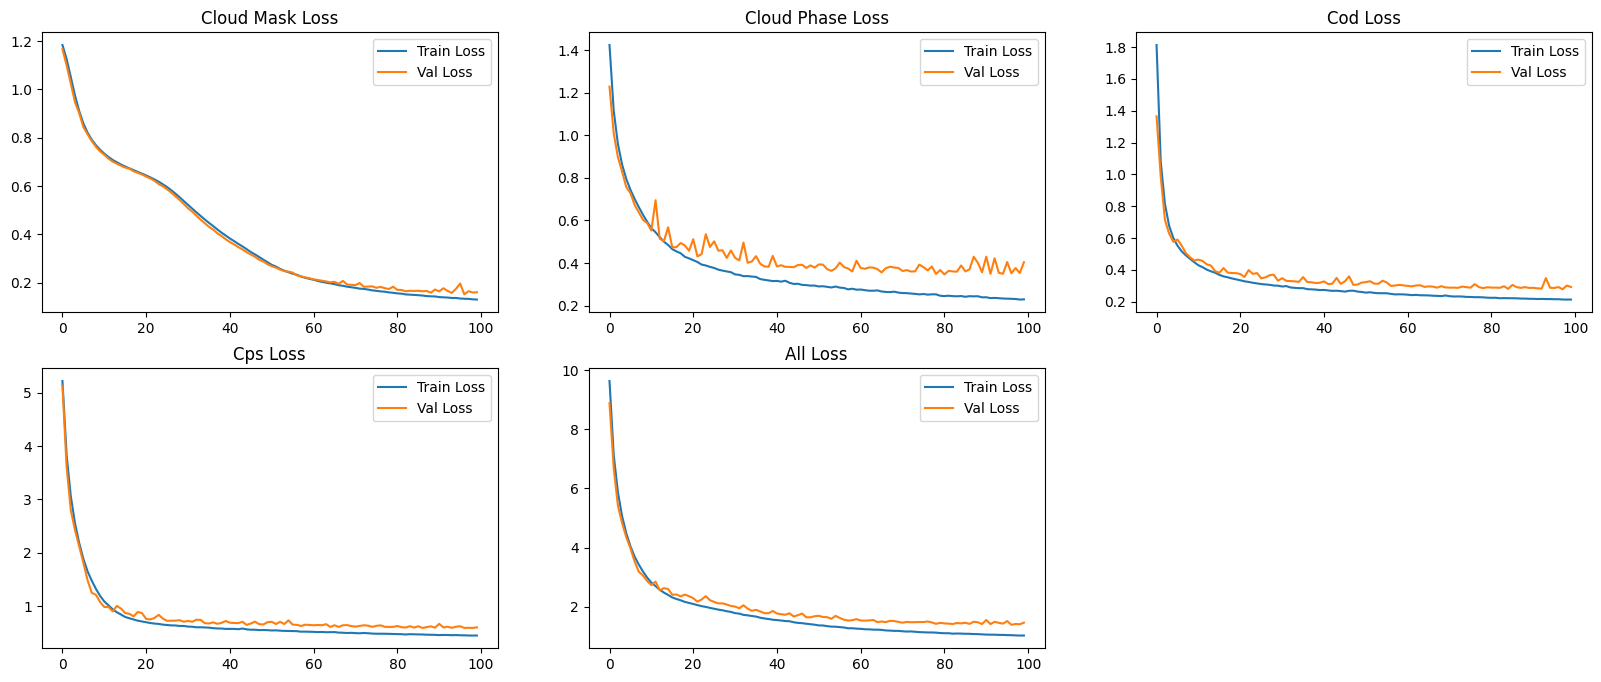

In [9]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV1_loss.png")  

plt.show()

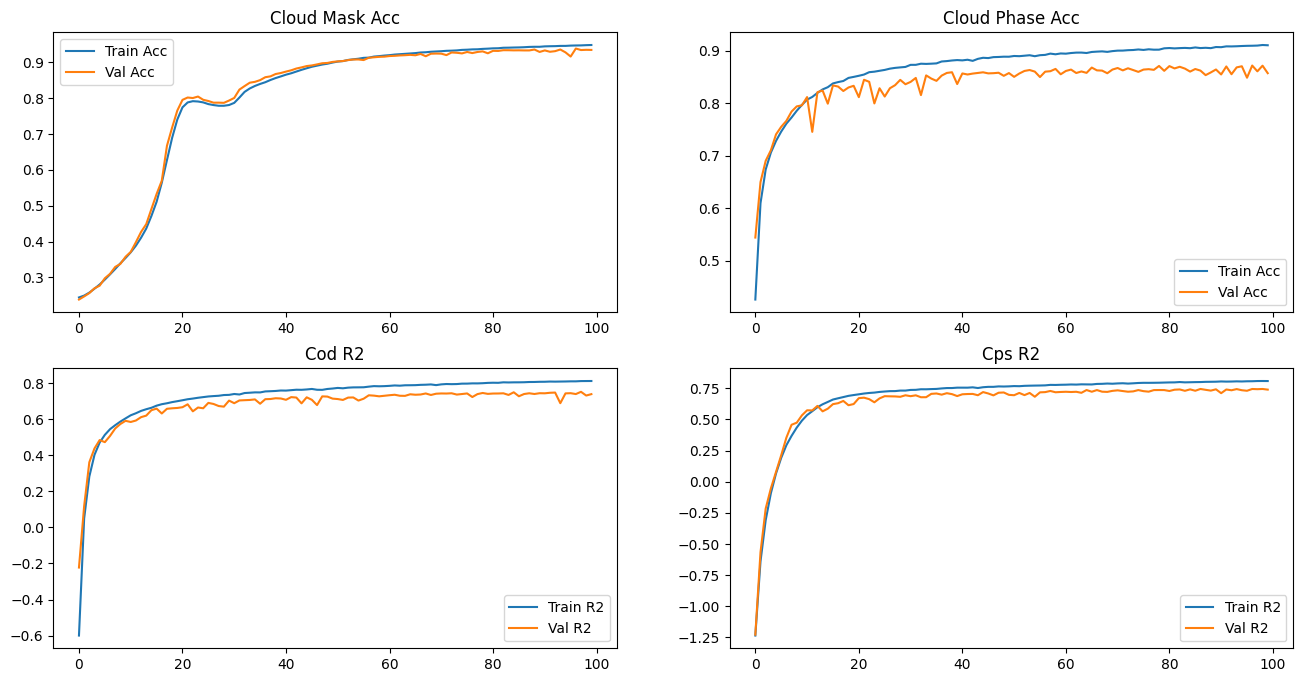

In [10]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()


plt.savefig("./graphs/MultiTaskV1_acc.png")  

plt.show()


In [11]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(2)])
supports = np.array([report[str(i)]['support'] for i in range(2)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:01<00:00,  8.01it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.923     0.770     0.840   5803166
           1      0.932     0.980     0.956  18740066

    accuracy                          0.930  24543232
   macro avg      0.927     0.875     0.898  24543232
weighted avg      0.930     0.930     0.928  24543232

CONFUSION MATRIX:
 [[ 4469794  1333372]
 [  375326 18364740]]

IOU: [0.72344417 0.91487766]
Unweighted IoU: 0.819160913999927
Weighted IoU: 0.8696138445924425


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:01<00:00,  7.74it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.921     0.778     0.843   4373397
           1      0.854     0.936     0.893  10864796
           2      0.697     0.898     0.785   2400565
           3      0.480     0.359     0.411    890044
           4      0.938     0.809     0.868   6014430

    accuracy                          0.852  24543232
   macro avg      0.778     0.756     0.760  24543232
weighted avg      0.858     0.852     0.850  24543232

CONFUSION MATRIX:
 [[ 3402366   898512    28686      580    43253]
 [  247730 10168468   274040    12754   161804]
 [    3323   164643  2155365    55989    21245]
 [     941    53572   418977   319758    96796]
 [   40695   618423   214336   277402  4863574]]

IOU: [0.72916916 0.80702473 0.64597567 0.25854303 0.76742446]
Unweighted IoU: 0.6416274081939981
Weighted IoU: 0.7478048202003822


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  8.19it/s]


r2: 0.7398495674133301
MSE: 0.29949644207954407


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


r2: 0.7415972948074341
MSE: 0.6207765340805054
